# Imbalanced problems

### Problemas de clasificación

Soluciones: agregar pesos, undersampling, SMOTE, oversampling:

In [1]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
import time

# Create synthetic imbalanced dataset
X, y = make_classification(n_samples=10000, n_features=5, n_classes=2, weights=[0.99, 0.01], random_state=42, class_sep=0.5)

# Add noise to the majority class
noise_indices = np.random.choice(np.where(y == 0)[0], size=int(0.2 * np.sum(y == 0)), replace=False)
X[noise_indices, :] += np.random.normal(0, 2, size=(len(noise_indices), X.shape[1]))

# Calculate the scale_pos_weight
ratio = float(np.sum(y == 0)) / np.sum(y == 1)
print(f'scale_pos_weight: {ratio}')

# Calculate weights using compute_class_weight
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weight_dict = {0: weights[0], 1: weights[1]}
print(f'compute_class_weight: {weight_dict}')

# Initialize models
model_no_weights = xgb.XGBClassifier(random_state=42)
model_manual_weights = xgb.XGBClassifier(scale_pos_weight=ratio, random_state=42)
model_compute_class_weights = xgb.XGBClassifier(scale_pos_weight=weights[1]/weights[0], random_state=42)
model_undersampling = xgb.XGBClassifier(random_state=42)
model_smote = xgb.XGBClassifier(random_state=42)
model_oversampling = xgb.XGBClassifier(random_state=42)

# Cross-validation using StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start_time_no_weights = time.time()
f1_no_weights = np.mean(cross_val_score(model_no_weights, X, y, scoring='f1', cv=cv))
end_time_no_weights = time.time()

start_time_manual_weights = time.time()
f1_manual_weights = np.mean(cross_val_score(model_manual_weights, X, y, scoring='f1', cv=cv))
end_time_manual_weights = time.time()

start_time_compute_class_weights = time.time()
f1_compute_class_weights = np.mean(cross_val_score(model_compute_class_weights, X, y, scoring='f1', cv=cv))
end_time_compute_class_weights = time.time()

# Pipeline for undersampling
undersampling_pipeline = Pipeline([
    ('undersample', RandomUnderSampler(sampling_strategy='majority')),
    ('classifier', model_undersampling)
])
start_time_undersampling = time.time()
f1_undersampling = np.mean(cross_val_score(undersampling_pipeline, X, y, scoring='f1', cv=cv))
end_time_undersampling = time.time()

# Pipeline for SMOTE
smote_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', model_smote)
])
start_time_smote = time.time()
f1_smote = np.mean(cross_val_score(smote_pipeline, X, y, scoring='f1', cv=cv))
end_time_smote = time.time()

# Pipeline for RandomOverSampler
oversampling_pipeline = Pipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('classifier', model_oversampling)
])
start_time_oversampling = time.time()
f1_oversampling = np.mean(cross_val_score(oversampling_pipeline, X, y, scoring='f1', cv=cv))
end_time_oversampling = time.time()

print(f"F1-score without weights: {np.round(f1_no_weights, 3)}. Time: {np.round(end_time_no_weights-start_time_no_weights, 3)} seconds.")
print(f"F1-score with manual weights: {np.round(f1_manual_weights, 3)}. Time: {np.round(end_time_manual_weights-start_time_manual_weights, 3)} seconds.")
print(f"F1-score with compute_class_weight: {np.round(f1_compute_class_weights, 3)}. Time: {np.round(end_time_compute_class_weights-start_time_compute_class_weights, 3)} seconds.")
print(f"F1-score with undersampling: {np.round(f1_undersampling, 3)}. Time: {np.round(end_time_undersampling-start_time_undersampling, 3)} seconds.")
print(f"F1-score with SMOTE: {np.round(f1_smote, 3)}. Time: {np.round(end_time_smote-start_time_smote, 3)} seconds.")
print(f"F1-score with oversampling: {np.round(f1_oversampling, 3)}. Time: {np.round(end_time_oversampling-start_time_oversampling, 3)} seconds.")


scale_pos_weight: 65.2251655629139
compute_class_weight: {0: 0.5076657528683115, 1: 33.11258278145695}
F1-score without weights: 0.012. Time: 0.352 seconds.
F1-score with manual weights: 0.091. Time: 0.318 seconds.
F1-score with compute_class_weight: 0.091. Time: 0.328 seconds.
F1-score with undersampling: 0.048. Time: 0.191 seconds.
F1-score with SMOTE: 0.055. Time: 0.457 seconds.
F1-score with oversampling: 0.046. Time: 0.373 seconds.


### Problemas de regresión:

Usando inverse probability weighting:

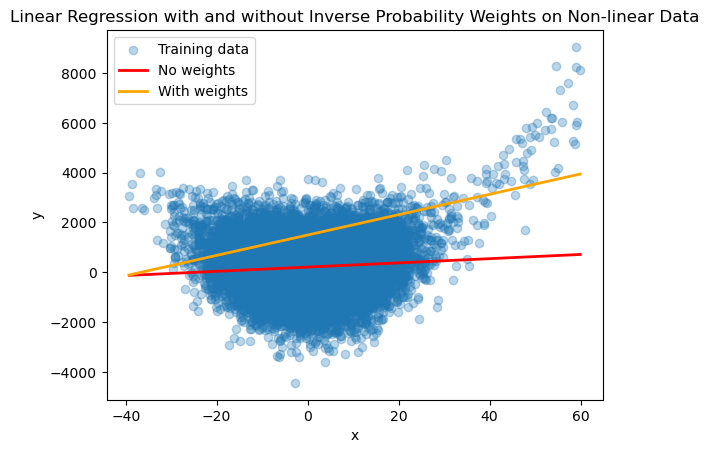

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde

# Step 1: Generate the dataset
np.random.seed(42)
x = np.concatenate([np.random.normal(0, 10, 20000), np.random.uniform(60, 30, 100)])
y = (2 * x**2 + 3) + np.random.normal(0, 1000, size=x.shape)

# Step 2: Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1, 1), y, test_size=0.2, random_state=42)

# Step 3: Train a model without sample weights
lr_no_weights = LinearRegression()
lr_no_weights.fit(x_train, y_train)

# Step 4: Train a model with sample weights
kde = gaussian_kde(x_train.flatten())
probability_density = kde(x_train.flatten())
sample_weights = 1 / (probability_density)

lr_weights = LinearRegression()
lr_weights.fit(x_train, y_train, sample_weight=sample_weights)

# Step 5: Plot the predictions
x_plot = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
y_no_weights = lr_no_weights.predict(x_plot)
y_weights = lr_weights.predict(x_plot)

plt.scatter(x_train, y_train, alpha=0.3, label="Training data")
plt.plot(x_plot, y_no_weights, label="No weights", linewidth=2, color='r')
plt.plot(x_plot, y_weights, label="With weights", linewidth=2, color='orange')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Regression with and without Inverse Probability Weights on Non-linear Data")
plt.show()

# Paralelización:

Se puede paralelizar en los distintos cores del computador. Para computadores con tarjeta de video NVIDIA, se puede usar la GPU:

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import time

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
data = pd.read_csv(url, header=None)
data = data.loc[0:500000,]

# Preprocess the dataset
X, y = data.iloc[:, :-1], data.iloc[:, -1]
y = y - 1  # Adjust labels to be zero-indexed

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model without parallelization
params = {'objective': 'multi:softmax', 'num_class': 7, 'n_jobs': 1}

print("Training model without parallelization.")
start_time = time.time()
model = xgb.train(params, xgb.DMatrix(X_train, label=y_train))
elapsed_time_no_parallel = time.time() - start_time

# Train the model with parallelization
params_parallel = {'objective': 'multi:softmax', 'num_class': 7, 'n_jobs': -1}

print("Training model with parallelization.")
start_time_parallel = time.time()
model_parallel = xgb.train(params_parallel, xgb.DMatrix(X_train, label=y_train))
elapsed_time_parallel = time.time() - start_time_parallel

# Print the time comparisons
print(f"Training time without parallelization: {elapsed_time_no_parallel:.2f} seconds")
print(f"Training time with parallelization: {elapsed_time_parallel:.2f} seconds")


Training model without parallelization.
Training model with parallelization.
Training time without parallelization: 4.04 seconds
Training time with parallelization: 1.37 seconds


# Learning rates

Entre más alto el learning rate, más rápido converge el algoritmo pero no necesariamente llega al óptimo:

[0]	eval-logloss:0.63758
[66]	eval-logloss:0.48833
[0]	eval-logloss:0.62416
[43]	eval-logloss:0.49898
[0]	eval-logloss:0.57874
[18]	eval-logloss:0.51932
[0]	eval-logloss:0.54629
[15]	eval-logloss:0.56275
[0]	eval-logloss:0.52600
[13]	eval-logloss:0.58515


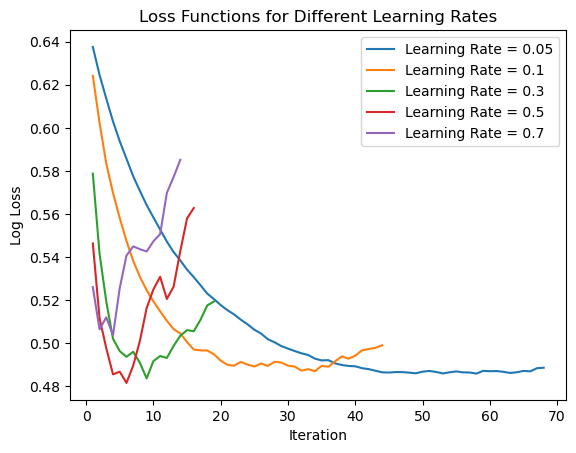

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_csv(url, names=names)
X, y = data.iloc[:, :-1], data.iloc[:, -1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
param = {
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
num_round = 100

# Train XGBoost with different learning rates
learning_rates = [0.05, 0.1, 0.3, 0.5, 0.7]
loss_history = {}

for lr in learning_rates:
    param['eta'] = lr
    
    evals_result = {}  # Store evaluation results
    bst = xgb.train(param, dtrain, num_round, early_stopping_rounds=10, evals=[(dtest, 'eval')], evals_result=evals_result, verbose_eval=100)
    
    loss_history[lr] = evals_result['eval']['logloss']

# Plot the loss functions for each learning rate
for lr, losses in loss_history.items():
    plt.plot(range(1, len(losses) + 1), losses, label=f"Learning Rate = {lr}")

plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.legend()
plt.title("Loss Functions for Different Learning Rates")
plt.show()


# Tiempos de entrenamiento e iteraciones con distintos learning rates

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import time

# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_csv(url, names=names)
X, y = data.iloc[:, :-1], data.iloc[:, -1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
param = {
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
num_round = 5000

# Train XGBoost with different learning rates
learning_rates = [0.001, 0.1]

for lr in learning_rates:
    param['eta'] = lr
    print(f"\nTraining with learning rate: {lr}")
    
    start_time = time.time()
    evals_result = {}  # Store evaluation results
    bst = xgb.train(param, dtrain, num_round, early_stopping_rounds=10, evals=[(dtest, 'eval')], evals_result=evals_result, verbose_eval=1000)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")



Training with learning rate: 0.001
[0]	eval-logloss:0.65153
[1000]	eval-logloss:0.51813
[2000]	eval-logloss:0.49033
[2180]	eval-logloss:0.48976
Elapsed time: 0.74 seconds

Training with learning rate: 0.1
[0]	eval-logloss:0.62416
[43]	eval-logloss:0.49898
Elapsed time: 0.02 seconds


# Overfitting

Para medir overfitting se debe comparar el desempeño del modelo en train y en test:

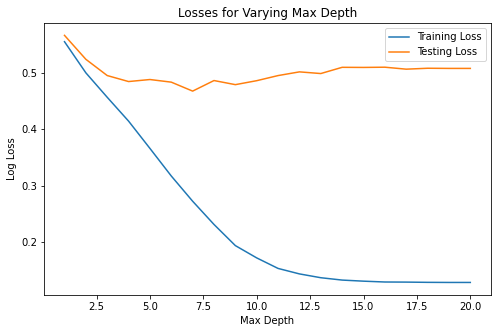

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_csv(url, names=names)
X, y = data.iloc[:, :-1], data.iloc[:, -1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vary max_depth hyperparameter
max_depths = list(range(1, 21))
train_losses_depth = []
test_losses_depth = []

for max_depth in max_depths:
    rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)
    
    train_proba = rf.predict_proba(X_train)
    test_proba = rf.predict_proba(X_test)
    
    train_loss = log_loss(y_train, train_proba)
    test_loss = log_loss(y_test, test_proba)
    
    train_losses_depth.append(train_loss)
    test_losses_depth.append(test_loss)

# Plot the training and testing losses for max_depth
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

ax1.plot(max_depths, train_losses_depth, label="Training Loss")
ax1.plot(max_depths, test_losses_depth, label="Testing Loss")
ax1.set_xlabel("Max Depth")
ax1.set_ylabel("Log Loss")
ax1.legend()
ax1.set_title("Losses for Varying Max Depth")

plt.show()


# Importancia de las variables y Shap values

Feature importances:
variance: 0.5979230403900146
skewness: 0.22082576155662537
curtosis: 0.12114560604095459
entropy: 0.0601055733859539


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


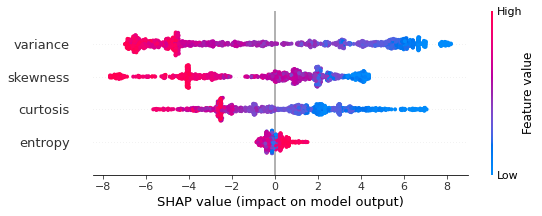

In [7]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
data = pd.read_csv(url, names=names)
X, y = data.iloc[:, :-1], data.iloc[:, -1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Compute and display feature importances
importances = model.feature_importances_
print("Feature importances:")
for name, importance in zip(X.columns, importances):
    print(f"{name}: {importance}")

# Compute and display SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Plot a summary plot for SHAP values
shap.summary_plot(shap_values, X)


# Regularización y overfitting

El uso de métodos de regularización puede ayudar a controlar el overfitting:

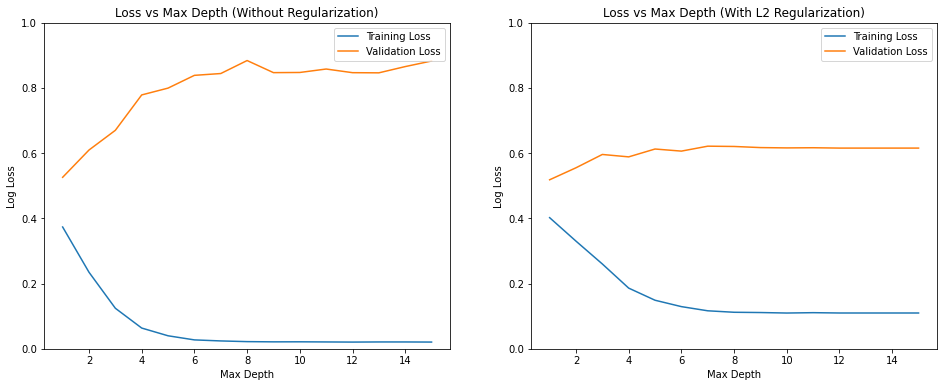

In [8]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_csv(url, names=names)
X, y = data.iloc[:, :-1], data.iloc[:, -1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

train_losses_reg = []
val_losses_reg = []

max_depths = list(range(1, 16))

for max_depth in max_depths:
    # Train XGBoost without regularization
    xgb_model = xgb.XGBClassifier(max_depth=max_depth, random_state=42, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    train_loss = log_loss(y_train, xgb_model.predict_proba(X_train))
    val_loss = log_loss(y_test, xgb_model.predict_proba(X_test))
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Train XGBoost with L2 regularization (reg_lambda)
    xgb_model_reg = xgb.XGBClassifier(max_depth=max_depth, reg_lambda=20, random_state=42, n_jobs=-1)
    xgb_model_reg.fit(X_train, y_train)
    train_loss_reg = log_loss(y_train, xgb_model_reg.predict_proba(X_train))
    val_loss_reg = log_loss(y_test, xgb_model_reg.predict_proba(X_test))
    train_losses_reg.append(train_loss_reg)
    val_losses_reg.append(val_loss_reg)

# Plot the training and validation losses without regularization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(max_depths, train_losses, label="Training Loss")
ax1.plot(max_depths, val_losses, label="Validation Loss")
ax1.set_title("Loss vs Max Depth (Without Regularization)")
ax1.set_xlabel("Max Depth")
ax1.set_ylabel("Log Loss")
ax1.legend()
ax1.set_ylim(0, 1)  # Set the y-axis scale

# Plot the training and validation losses with L2 regularization (reg_lambda)
ax2.plot(max_depths, train_losses_reg, label="Training Loss")
ax2.plot(max_depths, val_losses_reg, label="Validation Loss")
ax2.set_title("Loss vs Max Depth (With L2 Regularization)")
ax2.set_xlabel("Max Depth")
ax2.set_ylabel("Log Loss")
ax2.legend()
ax2.set_ylim(0, 1)  # Set the y-axis scale

plt.show()
